# Importing libraries and functions
            
Importing required libraries

In [0]:
# Importing required libraries

import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as K
from tensorflow.keras import Input, Model
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Softmax, Multiply, Lambda, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
from matplotlib import pyplot as plt
import os
import sys



In [0]:
def make_dir(path): # Function to make adirectory to save files in
    cwd = os.getcwd()
    abs_path = cwd + path



    if not os.path.exists(abs_path):
        try: 
            os.makedirs(abs_path)
            print(abs_path)
        except OSError:return 0
        else: return 1
    else: return 2

In [0]:
def get_APE(pred,y_true):# Function to return an array with APE of each prediction 
    APE = np.zeros(y_true.shape[0])
    for i in range(y_true.shape[0]):
        APE[i] = abs((pred[i] - y_true[i]) / y_true[i])

    return APE

def get_max_APE(APE): # Function to return the maximum APE with index value
    max_APE = np.zeros(2)

    for i in range(40, 160):
        if APE[i] > max_APE[0]:
            max_APE[0] = APE[i]
            max_APE[1] = i
    return max_APE

In [0]:
# Declaring Variables
num_epochs = 2000000

# Filepaths for saving Model Checkpoints:
save_post_dir = 'PostProc/'

In [0]:
# Reading data from .csv file
data_dat = pd.read_csv (r'data.csv')
pred_dat = pd.read_csv (r'test.csv')

In [0]:
# Extracting data into numpy arrays from pandas DataFrames

# Training data
X = pd.DataFrame(data_dat, columns = ['LD'])
X = X.to_numpy()

X_n = pd.DataFrame(data_dat, columns = ['XL'])
X_n = X_n.to_numpy()


y = pd.DataFrame(data_dat, columns = ['Ma'])
y = y.to_numpy()

# Prediction data
X_pred = pd.DataFrame(pred_dat, columns = ['LD'])
X_pred = X_pred.to_numpy()
X_pred_ns = X_pred

X_n_pred = pd.DataFrame(pred_dat, columns = ['XL'])
X_n_pred = X_n_pred.to_numpy()

y_pred = pd.DataFrame(pred_dat, columns = ['Ma'])
y_pred = y_pred.to_numpy()



In [0]:
# Returns normalised valeus of Mach Number and Maximum Mach Number per L/D ratio as two arrays

def get_norm_y(y,c): 
    num = int(y.shape[0] / c)
    max_val = np.zeros(c*num)
    y_norm = np.zeros([num*c])
    for i in range(num):
        max_val[i*c:(i+1)*c] = max(y[i*c:(i+1)*c])
        for j in range(c):
            y_norm[i*c + j] = y[i*c+j]/max_val[i*c+j]
    return y_norm, max_val
    
y_norm, max_y = get_norm_y(y, 201)
y_pred_norm, max_y_pred = get_norm_y(y_pred, 201)

# Returns Input set fro training the Max Mach Numbers

def get_x(x,c):
    x_n = np.zeros(x.shape[0])
    
    for i in range(x.shape[0]):
        x_n[i] = x[i]
    
    return x_n

X_max = get_x(X,201)
X_pred_max = get_x(X_pred, 201)

X= np.hstack((X_n,X))
X_pred = np.hstack((X_n_pred,X_pred))

In [0]:
# Create a concatenated output file.
y_comb = np.zeros([y_norm.shape[0],2])
for i in range(y_comb.shape[0]):
    y_comb[i,0]=y_norm[i]
    y_comb[i,1]=max_y[i]

y_pred_comb = np.zeros([y_pred_norm.shape[0],2])
for i in range(y_pred_comb.shape[0]):
    y_pred_comb[i,0]=y_pred_norm[i]
    y_pred_comb[i,1]=max_y_pred[i]

In [0]:
MaxVal_archi = [5,5,5,5,5,5,5,5,5,5,5,5,1]
IndVal_archi = [20,20,20,20,20,20,20,20,20,20,20,20,1]

def get_LD(x): # Function to separate L/D Ratio for the Lambda Layer.
    x_new = x[:,1]
    return x_new[:,np.newaxis]

# Define a function to build a SN
def build_model(MaxVal_archi, IndVal_archi):
    Input_layer = Input(shape=[2,], name='Input')
    # Lambda layer to separately use it as only L/D ratio input for a fork in Network.
    MaxVal_input = Lambda(get_LD, name='MaxVal_input', output_shape=(1,))(Input_layer)
    # Defining the MaxVal fork of SN    
    MaxVal_layer = []
    for i,node in enumerate(MaxVal_archi):
        if i==0: # First layer in MaxVal fork
            MaxVal_layer.append(Dense(node, name='MaxVal_layer%d' %(i+1), activation='relu')(MaxVal_input))
        elif i==len(MaxVal_archi)-1: # Last layer in MaxVal fork. *Activation must be linear*
            MaxVal_layer.append(Dense(node, name='MaxVal_Final_layer', activation='linear')(MaxVal_layer[i-1]))
         else: # For intermediate layers
            MaxVal_layer.append(Dense(node, name='MaxVal_layer%d' %(i+1), activation='relu')(MaxVal_layer[i-1]))
    # Defining the IndVal fork of Neural Network
    IndVal_layer = []
    for i, node in enumerate(IndVal_archi):
        if i==0: # First layer in MaxVal fork
            IndVal_layer.append(Dense(node, name='IndVal_layer%d' %(i+1), activation='relu')(Input_layer))
        elif i==len(IndVal_archi)-1: # Last layer in MaxVal fork. *Activation must be linear*
            IndVal_layer.append(Dense(node, name='IndVal_Final_layer', activation='linear')(IndVal_layer[i-1])) 
        else: # For intermediate layers
            IndVal_layer.append(Dense(node, name='IndVal_layer%d' %(i+1), activation='relu')(IndVal_layer[i-1]))

    # Building the model with all connections            
    model = Model(inputs= [Input_layer], outputs= [IndVal_layer[len(IndVal_archi)-1], MaxVal_layer[len(MaxVal_archi)-1]])
    return model

model = build_model(MaxVal_archi,IndVal_archi)

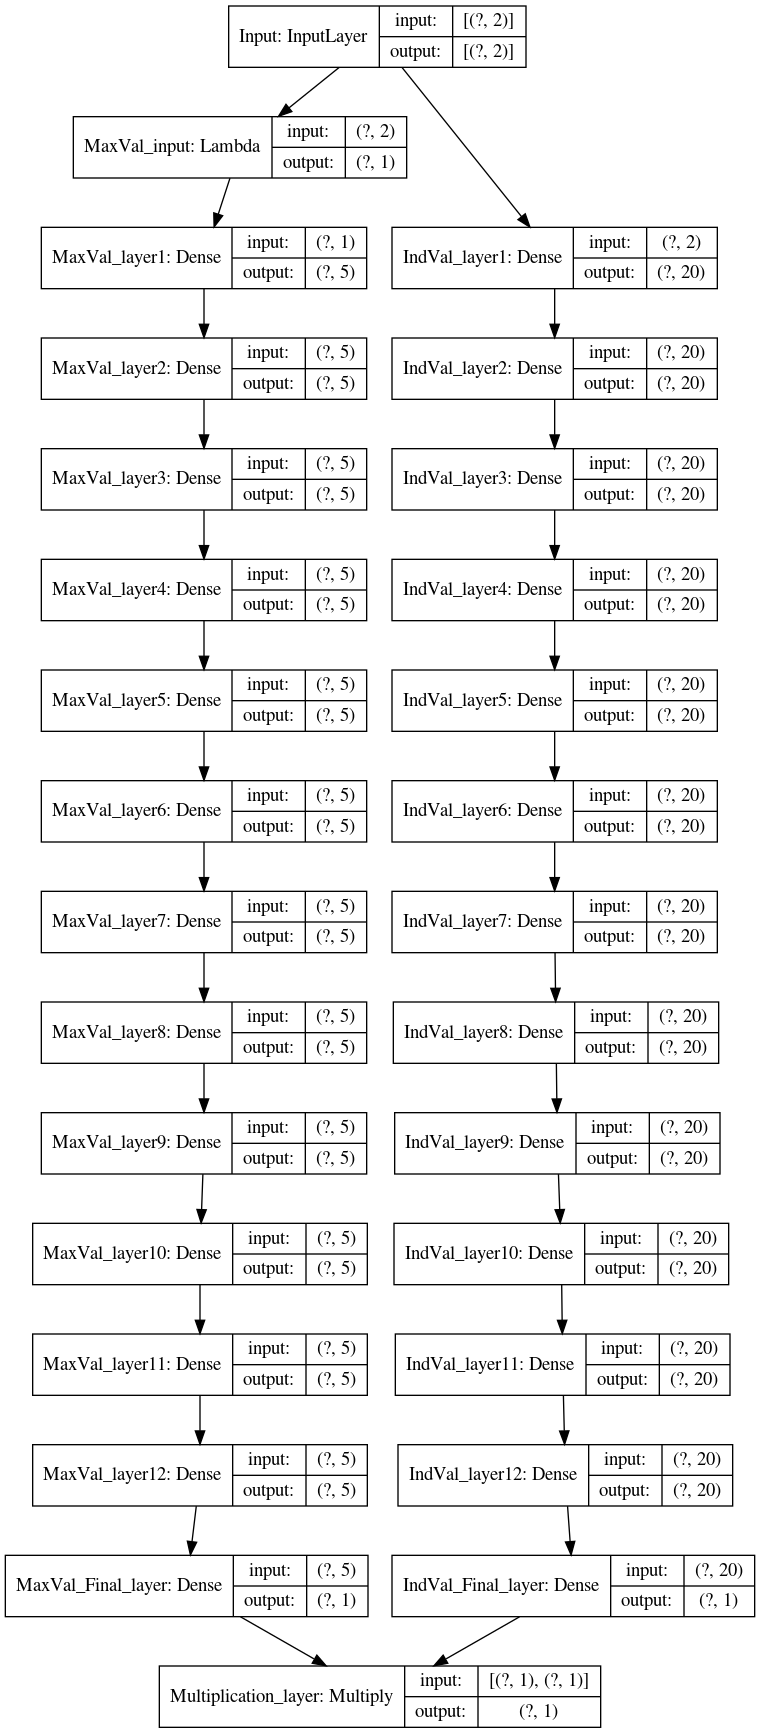

In [0]:
# A visual flowchart of the model.
keras.utils.plot_model(model, "SNwithoutMult.png", show_shapes=True)

In [0]:
SGD_NM = tf.keras.optimizers.SGD(learning_rate=0.01,
                                        momentum=0.1,
                                        nesterov=True)
model.compile(loss='mse', optimizer='Adam', metrics=['mape'])

In [0]:
early_stopping_callback = EarlyStopping(monitor='val_mape', 
                                        patience=200,
                                        min_delta= 1e-4,
                                        restore_best_weights=True,
                                        mode='auto',
                                        verbose=True)

In [0]:
##### Using sklearn to split the data into train and test sets with shuffling ####
X_train, X_test, y_train_comb, y_test_comb = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [0]:
history = model.fit(X_train,
                    (y_train_comb[:,0],y_train_comb[:,1]),
                    batch_size = 10,
                    epochs=1000000,
                    verbose=True,
                    validation_data=(X_test, (y_test_comb[:,0],y_test_comb[:,1])),
                    callbacks=[early_stopping_callback])
model.save('temp_models/SiameseModel3')

Train on 482 samples, validate on 121 samples
Epoch 1/1000000
482/482 [==============================] - 1s 1ms/sample - loss: 0.9235 - mape: 189.6244 - val_loss: 1.0473 - val_mape: 246.3184
Epoch 2/1000000
482/482 [==============================] - 0s 991us/sample - loss: 0.9189 - mape: 185.8993 - val_loss: 0.8977 - val_mape: 202.5465
Epoch 3/1000000
482/482 [==============================] - 0s 727us/sample - loss: 0.8630 - mape: 183.0277 - val_loss: 0.8879 - val_mape: 191.0868
Epoch 4/1000000
482/482 [==============================] - 0s 702us/sample - loss: 0.9684 - mape: 173.0482 - val_loss: 0.8478 - val_mape: 178.4632
Epoch 5/1000000
482/482 [==============================] - 0s 696us/sample - loss: 0.9244 - mape: 175.7446 - val_loss: 0.8875 - val_mape: 184.4276
Epoch 6/1000000
482/482 [==============================] - 0s 654us/sample - loss: 0.8431 - mape: 176.3024 - val_loss: 0.8345 - val_mape: 179.7637
Epoch 7/1000000
482/482 [==============================] - 0s 778us/sample

In [0]:
prediction = model.predict(X_pred)
pred = prediction[0]*prediction[1]

<Figure size 432x288 with 0 Axes>

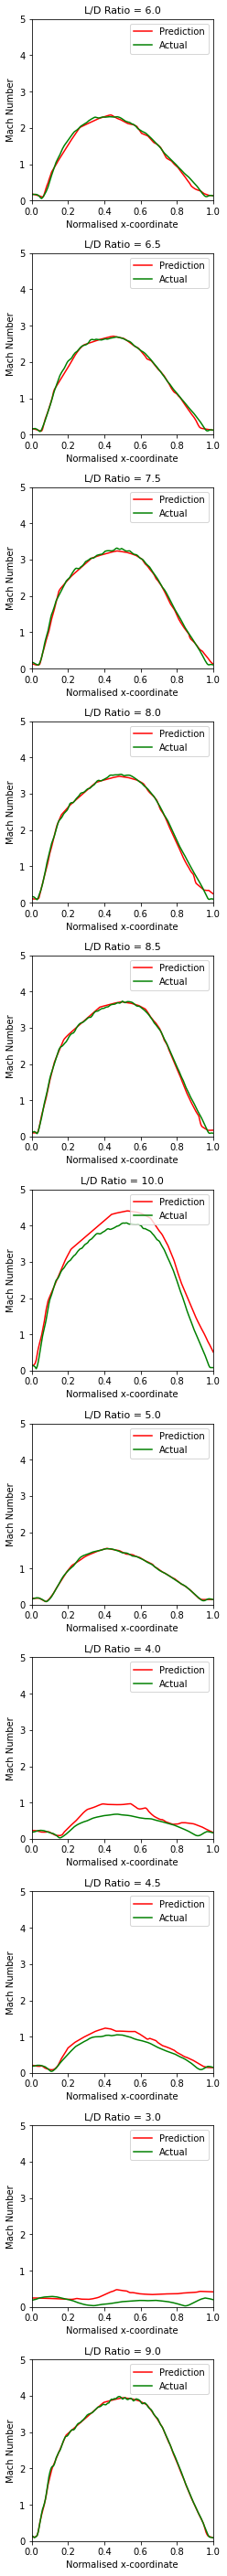

In [0]:
nrows=int(X_pred.shape[0]/201)
fig3 = plt.figure()
fig, axes = plt.subplots(nrows)
fig.set_size_inches(6,39)
for j in range(nrows):
    axes[j].plot(X_n_pred[:201],
                  pred[j*201:(j+1)*201],
                  'r',
                  label='Prediction')
    axes[j].plot(X_n_pred[j*201:(j+1)*201], y_pred[j*201:(j+1)*201], 'g', label='Actual')
    axes[j].set(xlabel="Normalised x-coordinate", ylabel="Mach Number")
    axes[j].set_title('L/D Ratio = %.1f' %(X_pred_max[201*j]), fontsize=11)
    axes[j].legend(loc="upper right")
    axes[j].set_xlim((0,1))
    axes[j].set_ylim((0,5))
    axes[j].set_aspect(0.2)

fig = plt.gcf()
plt.tight_layout(pad=0.25, h_pad=1.25, w_pad=0.25, rect=None)
# plt.savefig(save_post_dir + 'cumilative_ind_%s_predictions.png' %(opti_name), dpi=500)
plt.show(fig3)
plt.close(fig3)

In [0]:
model = load_model('')

In [0]:
pred = model.predict(X_pred)
for i in range(int(X_pred.shape[0]/201)):
    max_val = get_max_APE(get_APE(pred[i*201:(i+1)*201],y_pred[i*201:(i+1)*201]))
    print("For L/D = %.1f, the MAPE is %f at x: %f" %(X_pred[i*201,1],
                                                      max_val[0],
                                                      max_val[1]))

For L/D = 6.0, the MAPE is 0.083409 at x: 40.000000
For L/D = 6.5, the MAPE is 0.085104 at x: 40.000000
For L/D = 7.5, the MAPE is 0.045376 at x: 153.000000
For L/D = 8.0, the MAPE is 0.046498 at x: 159.000000
For L/D = 8.5, the MAPE is 0.038308 at x: 40.000000
For L/D = 10.0, the MAPE is 0.122350 at x: 157.000000
For L/D = 5.0, the MAPE is 0.052257 at x: 54.000000
For L/D = 4.0, the MAPE is 0.666075 at x: 40.000000
For L/D = 4.5, the MAPE is 0.330036 at x: 40.000000
For L/D = 3.0, the MAPE is 5.286397 at x: 69.000000
For L/D = 9.0, the MAPE is 0.021156 at x: 82.000000


In [0]:
model = load_model('temp_models/SiameseModel3')
# print(model.summary())
# input_layer = model.get_layer('MaxVal_layer1').input
intermediate_layer = model.get_layer('IndVal_Final_layer').output
model_intermediate = Model(inputs=model.input, outputs=intermediate_layer)
intermediate_prediction=model_intermediate.predict(X_pred)

In [0]:
for i in range(int(pred.shape[0]/201)):
    plt.plot(X_n_pred[i*201:(i+1)*201], intermediate_prediction[i*201:(i+1)*201], 'r', label='Prediction')
    plt.plot(X_n_pred[i*201:(i+1)*201],y_pred_norm[i*201:(i+1)*201], 'g', label='Actual')
    plt.legend(loc='upper right')
    plt.title('L/D Ratio = %.1f' %(X_pred[i*201,1]))
    plt.show()
    plt.close